In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from data import ModelNet40,download,load_data
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from geomloss import SamplesLoss
%matplotlib inline

In [5]:
def quat2mat(quat):
    x, y, z, w = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]

    B = quat.size(0)

    w2, x2, y2, z2 = w.pow(2), x.pow(2), y.pow(2), z.pow(2)
    wx, wy, wz = w*x, w*y, w*z
    xy, xz, yz = x*y, x*z, y*z

    rotMat = torch.stack([w2 + x2 - y2 - z2, 2*xy - 2*wz, 2*wy + 2*xz,
                          2*wz + 2*xy, w2 - x2 + y2 - z2, 2*yz - 2*wx,
                          2*xz - 2*wy, 2*wx + 2*yz, w2 - x2 - y2 + z2], dim=1).reshape(B, 3, 3)
    return rotMat


def transform_point_cloud(point_cloud, rotation, translation):
    if len(rotation.size()) == 2:
        rot_mat = quat2mat(rotation)
    else:
        rot_mat = rotation
    return torch.matmul(rot_mat, point_cloud) + translation.unsqueeze(2)

In [6]:
device = torch.device("cuda:0")

In [7]:
data = ModelNet40(num_points=2048, partition='train', gaussian_noise=False,
                       unseen=False, factor=4)
train_loader = DataLoader(data, batch_size=30, shuffle=True, drop_last=True)

/home/gwu/ConvexICP/data.py:36: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_name)


In [8]:
data[0][0]

array([[ 0.05783484, -0.04216423, -0.11683752, ..., -0.07832377,
        -0.11032561,  0.13324134],
       [ 0.30058783,  0.38964763,  0.5078785 , ..., -0.7786398 ,
        -0.25679094,  0.11355276],
       [-0.20333372, -0.45547998, -0.03362782, ...,  0.12004923,
         0.29560417, -0.14605786]], dtype=float32)

In [24]:
earth_mover_distance(x,y)

tensor([629.8341], device='cuda:0')

In [60]:
data[0]

(array([[-0.10639593,  0.1944651 ,  0.03232793, ..., -0.03081613,
          0.22653179, -0.02792929],
        [ 0.03835556,  0.38123643, -0.45103848, ..., -0.19015461,
          0.30869976,  0.5612641 ],
        [ 0.23706123,  0.00968647, -0.00926619, ..., -0.0163727 ,
         -0.13992572, -0.28346834]], dtype=float32),
 array([[-0.26102367,  0.00440408, -0.6993001 , ..., -0.44741637,
         -0.2992318 , -0.6285225 ],
        [ 0.22742558, -0.28189605,  0.65985185, ...,  0.305594  ,
          0.5253664 ,  0.702616  ],
        [-0.10705105, -0.7669289 , -0.17531003, ...,  0.00556536,
         -0.09155586, -0.12173549]], dtype=float32),
 array([[ 0.6259179 , -0.5007024 ,  0.597933  ],
        [ 0.7522379 ,  0.5899465 , -0.29343018],
        [-0.20582727,  0.63345104,  0.7459054 ]], dtype=float32),
 array([-0.27205104,  0.19731395, -0.32443962], dtype=float32),
 array([[ 0.6259179 ,  0.7522379 , -0.20582727],
        [-0.5007024 ,  0.5899465 ,  0.63345104],
        [ 0.597933  , -0.293

In [63]:
ts = torch.matmul(x.permute(0,2,1),R)

In [64]:
ts.shape

torch.Size([1, 2048, 3])

In [65]:
ts

tensor([[[ 0.1617,  0.2755, -0.2864],
         [ 0.2584,  0.1644, -0.1190],
         [ 0.1006,  0.4634, -0.1348],
         ...,
         [-0.0834,  0.4167, -0.3714],
         [-0.0513,  0.1729, -0.4666],
         [ 0.0581,  0.1307, -0.5700]]], device='cuda:0')

In [69]:
ts+T-ts

tensor([[[-0.0206,  0.1601,  0.3980],
         [-0.0206,  0.1601,  0.3980],
         [-0.0206,  0.1601,  0.3980],
         ...,
         [-0.0206,  0.1601,  0.3980],
         [-0.0206,  0.1601,  0.3980],
         [-0.0206,  0.1601,  0.3980]]], device='cuda:0')

In [72]:
T

tensor([-0.0206,  0.1601,  0.3980], device='cuda:0')

In [62]:
earth_mover_distance(ts.permute(0,2,1),y)

tensor([711.3168], device='cuda:0')

In [27]:
ky = y[:,:,torch.randperm(1024)]

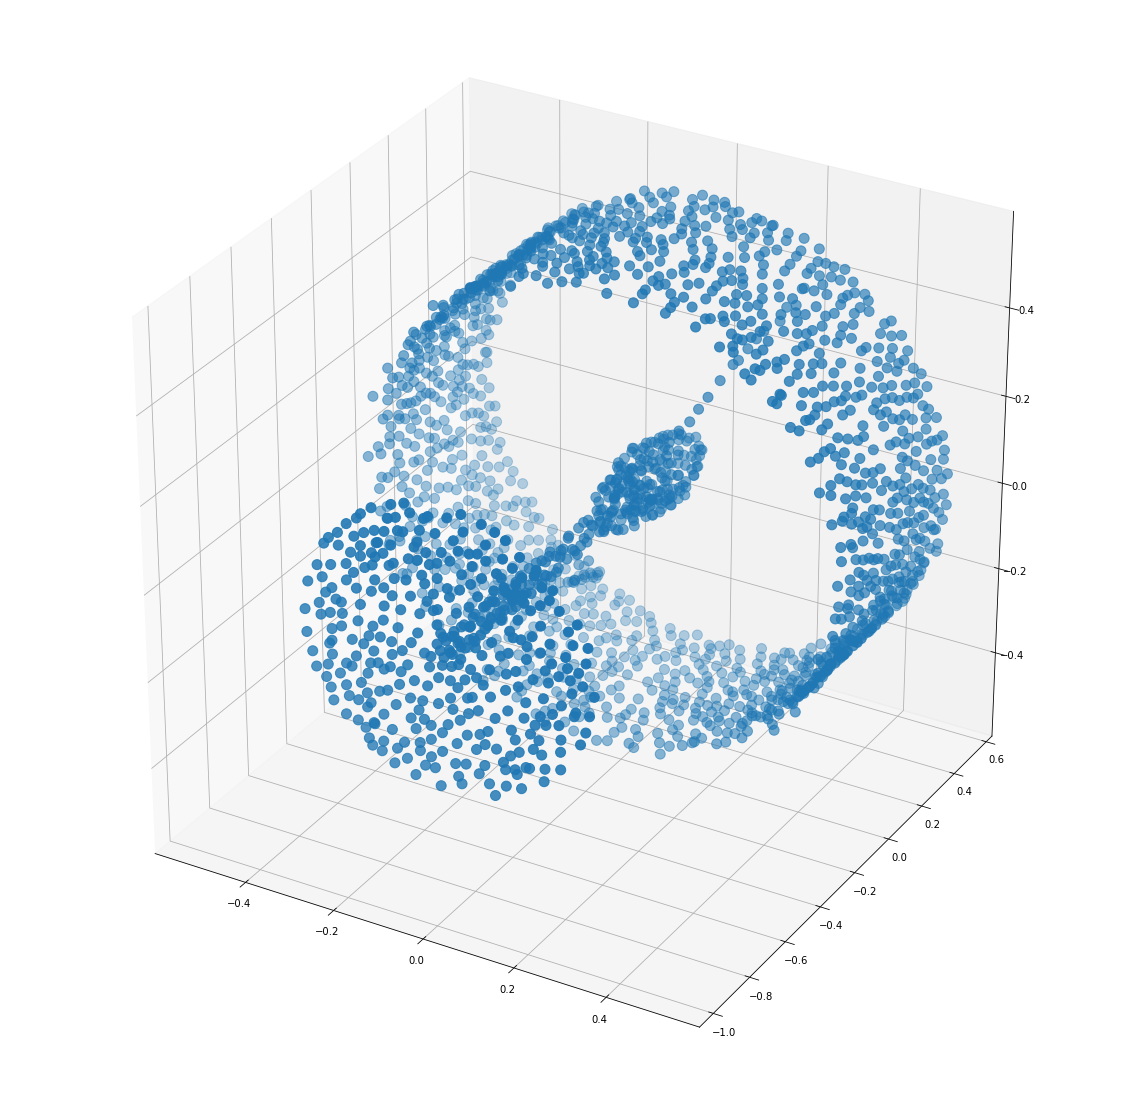

In [50]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[22][:,0], data[22][:,1], data[22][:,2], marker="o",s=100)

In [42]:
data, label = load_data("train")

In [74]:
for src, target, rotation_ab, translation_ab, rotation_ba, translation_ba, euler_ab, euler_ba in train_loader:
    src = src.cuda()
    target = target.cuda()
    rotation_ab = rotation_ab.cuda()
    translation_ab = translation_ab.cuda()
    rotation_ba = rotation_ba.cuda()
    translation_ba = translation_ba.cuda()
    break

In [94]:
trans_src = transform_point_cloud(src, rotation_ab, translation_ab)

In [95]:
target[0]

tensor([[ 0.2078, -0.1348, -0.2265,  ..., -0.4454, -0.4915, -0.2965],
        [-1.0950, -0.7852, -0.2796,  ..., -0.1426, -0.0525,  0.2837],
        [-0.4617, -0.3308, -0.2627,  ..., -0.1864, -0.1856, -0.2145]],
       device='cuda:0')

In [96]:
trans_src[0]

tensor([[ 0.1354, -0.2384, -0.2587,  ...,  0.0539, -0.1528, -0.1910],
        [-0.9751, -0.5944,  0.3337,  ..., -1.1251, -0.1312, -0.0866],
        [-0.4392, -0.3089, -0.2034,  ..., -0.4295, -0.2726, -0.2895]],
       device='cuda:0')

In [97]:
earth_mover_distance(target,trans_src)

tensor([1.0816e-02, 5.1692e-08, 2.9058e-08, 1.4669e-09, 4.1672e-09, 2.3983e-04,
        2.9380e-07, 1.4389e-10, 1.8554e-08, 1.4331e-09, 3.9915e-09, 1.1634e-09,
        3.6229e-06, 1.1857e-08, 7.6577e-08, 7.7213e-11, 1.2115e-10, 1.8882e-05,
        1.6513e-11, 5.1795e-03, 3.0551e-09, 2.3965e-02, 5.9734e-12, 1.3028e-02,
        6.5106e-08, 1.2632e-11, 7.9641e-05, 1.7801e-07, 5.3910e-04, 1.0473e-06],
       device='cuda:0')

In [9]:
class PointNet(nn.Module):
    def __init__(self, emb_dims=512):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1, bias=False)
        self.conv5 = nn.Conv1d(128, emb_dims, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(emb_dims)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        return x

In [20]:
class CPNet(nn.Module):
    def __init__(self, emb_dims=512):
        super(CPNet, self).__init__()
        self.base_net = PointNet()
        self.loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

        
    def forward(self, x1, x2, R, T):
        
        trans = torch.matmul(R, x1) + T.unsqueeze(2)
        emb1 = self.base_net(trans)
        emb2 = self.base_net(x2)
        
        dist = self.loss(emb1,emb2)

        return dist

In [26]:
def dummy_loss(output, target):
    loss = torch.mean(output)
    return loss

In [12]:
lr = 1e-2
momentum = 0.9
weight_decay = 5e-4

In [21]:
model = CPNet().to(device)

In [28]:
criterion = dummy_loss
optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)
best=0

In [32]:
for src, target, rotation_ab, translation_ab, rotation_ba, translation_ba, euler_ab, euler_ba in train_loader:
    src = src.cuda()
    target = target.cuda()
    rotation_ab = rotation_ab.cuda()
    translation_ab = translation_ab.cuda()
    rotation_ba = rotation_ba.cuda()
    translation_ba = translation_ba.cuda()
    a= model(src,target,rotation_ab,translation_ab)
    loss = criterion(a,target)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(330.2190, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(116.0330, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(33.6506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0657, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.3196, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.8327, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(392.6180, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(796.4780, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(983.0862, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1161.0963, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(788.9500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(310.9168, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(72.6401, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8201, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.6523, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4576, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.

KeyboardInterrupt: 

tensor(575.2001, device='cuda:0', grad_fn=<MeanBackward0>)